In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

import keras

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Reshape, Dense, Flatten, Dropout,MaxPooling2D, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
%matplotlib inline



Using TensorFlow backend.


In [8]:
# load bank dataset
bank = pd.read_csv('bank-1.csv')
#import io
#bank = pd.read_csv(io.StringIO(uploaded['bank-1.csv'].decode('utf-8')))

bank.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
bank.shape

(10000, 14)

In [10]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [11]:
bank.isnull().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [12]:
# No null values found
(bank<0).any()

RowNumber          False
CustomerId         False
Surname             True
CreditScore        False
Geography           True
Gender              True
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [13]:
bank.duplicated().any()

False

In [0]:
bank = bank.drop(['CustomerId','RowNumber','Surname'], axis=1)

In [15]:
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [16]:
bank.shape

(10000, 11)

In [17]:
# Convert / Label Encode Gender and Geography as they are independent variablees 
le_class = LabelEncoder()
bank["Gender"] = le_class.fit_transform(bank["Gender"])
bank["Gender"].value_counts()

1    5457
0    4543
Name: Gender, dtype: int64

In [18]:
bank["Geography"] = le_class.fit_transform(bank["Geography"])
bank["Geography"].value_counts()

0    5014
1    2509
2    2477
Name: Geography, dtype: int64

In [19]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null int64
Gender             10000 non-null int64
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9)
memory usage: 859.5 KB


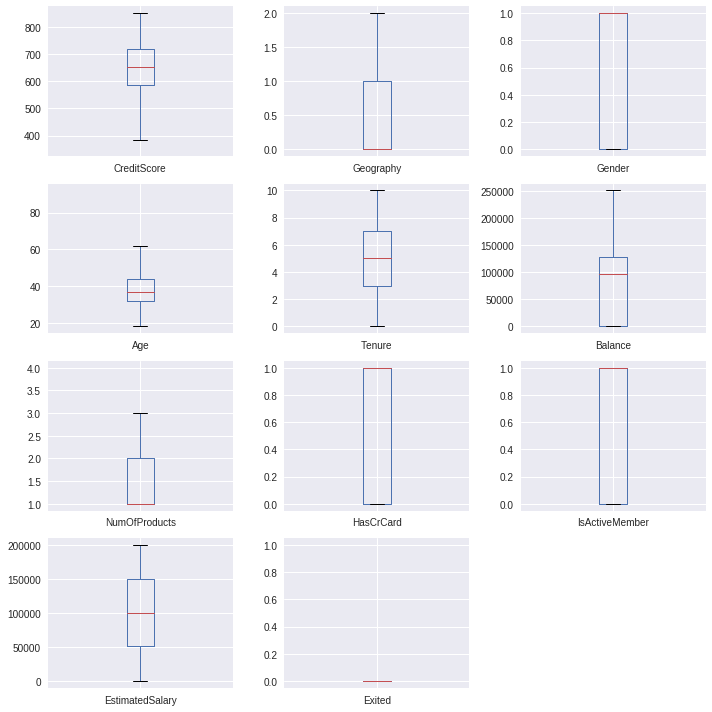

In [20]:
# Univariate Box Plots to check for outliers
fig, axes = plt.subplots(4,3,figsize=(10,10)) # create figure and axes

for i,el in enumerate(list(bank.columns.values)[:]):
    a = bank.boxplot(el, ax=axes.flatten()[i])

fig.delaxes(axes[3,2]) # remove empty subplot
plt.tight_layout() 
plt.show()

In [21]:
bank["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [22]:
# Removing outliers and assigning it to new dataframe

Q1 = bank.quantile(0.25)
Q3 = bank.quantile(0.75)
IQR = Q3 - Q1

bank_wo = bank[~((bank < (Q1 - 1.5 * IQR)) |(bank > (Q3 + 1.5 * IQR))).any(axis=1)]
bank_wo.shape

(7677, 11)

In [23]:
bank_wo["Exited"].value_counts()

0    7677
Name: Exited, dtype: int64

#### We can't remove outliers as it is removeing all rows with 1 i.e customers who exited from the bank

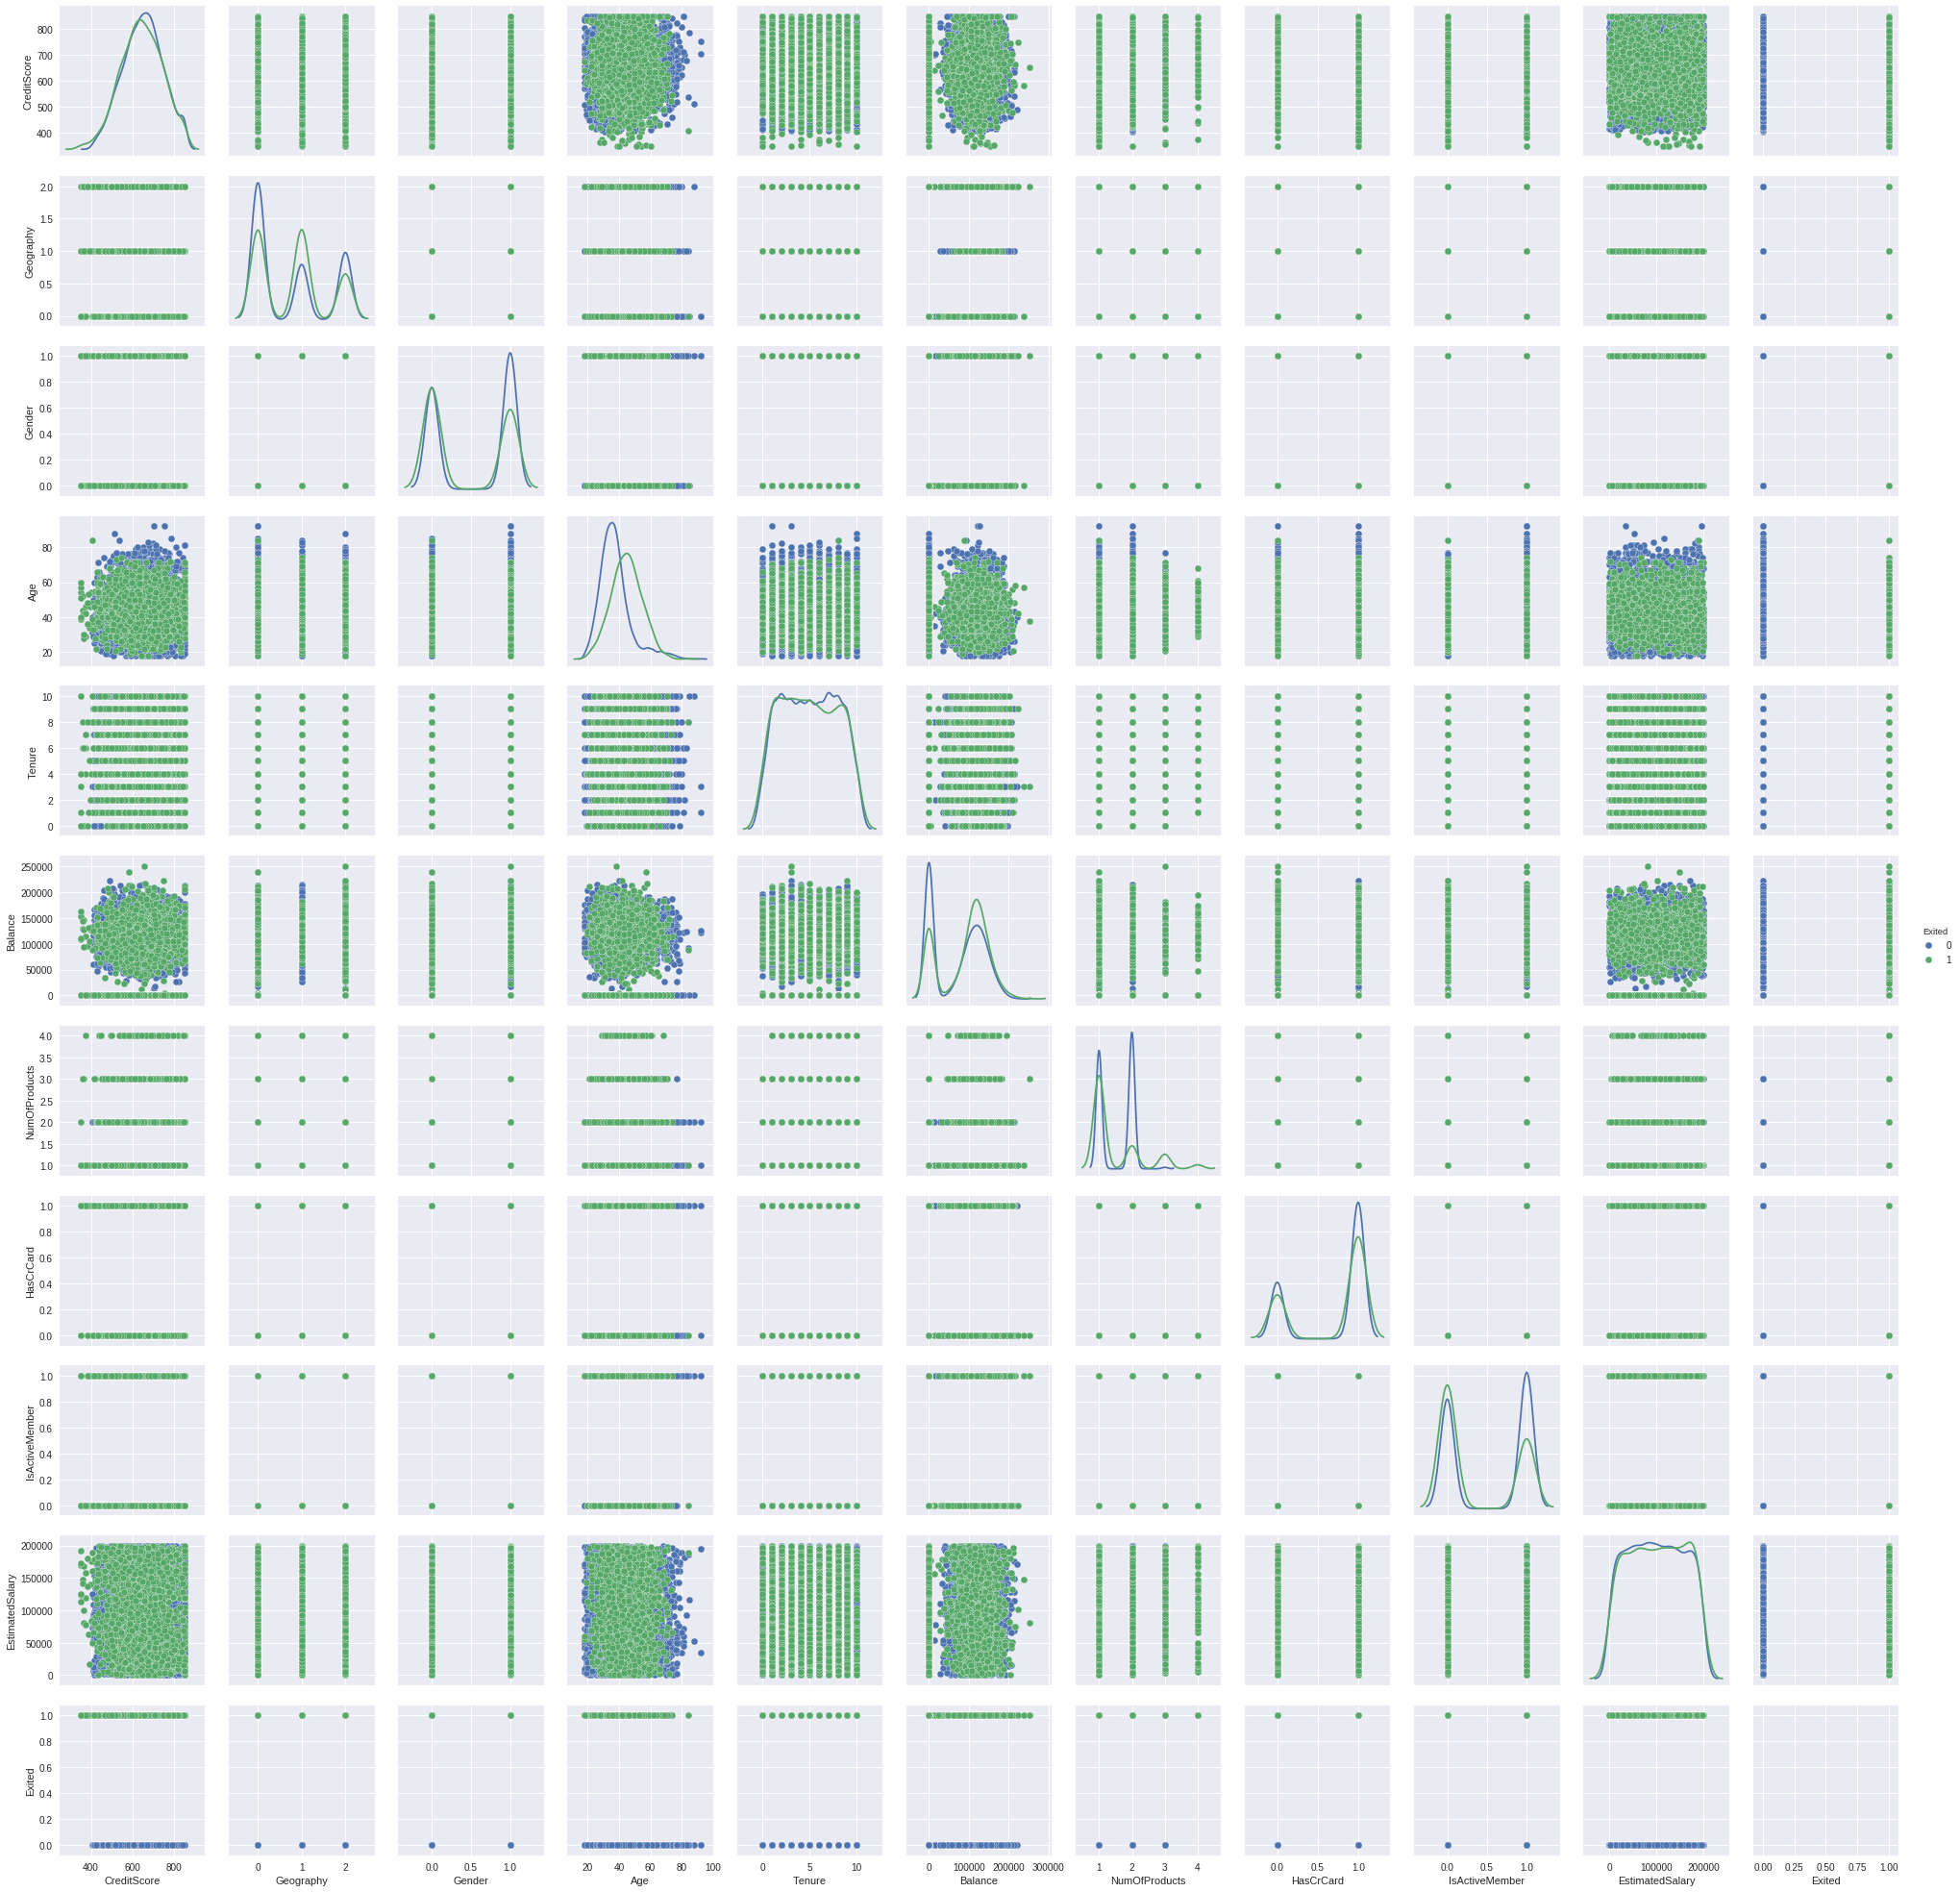

In [25]:
sns.pairplot(bank, diag_kind ="kde",hue="Exited")

In [26]:
bank_corr = bank.corr()
bank_corr[['Exited']]

,Exited
CreditScore,-0.027094
Geography,0.035943
Gender,-0.106512
Age,0.285323
Tenure,-0.014001
Balance,0.118533
NumOfProducts,-0.047820
HasCrCard,-0.007138
IsActiveMember,-0.156128
EstimatedSalary,0.012097


In [0]:
# Exited is the target variable and remaining are Features
X=bank.drop(['Exited'],axis=1)
y=bank[['Exited']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20 , random_state=1)

In [0]:
# Perform scaling of the data using Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled) # Creating dataframe
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled) # Creating dataframe

In [0]:
# Convert both training and testing labels into one-hot vectors and print first 5 examples
train_Y = tf.keras.utils.to_categorical(y_train)
test_Y = tf.keras.utils.to_categorical(y_test)

In [33]:
print(train_Y.shape)
print('First 5 examples now are: ', train_Y[0:5])

(8000, 2)
First 5 examples now are:  [[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [34]:
print(test_Y.shape)
print('First 5 examples now are: ', test_Y[0:5])

(2000, 2)
First 5 examples now are:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [36]:
# Get number of columns in X_train
X_col = X_train_scaled.shape[1]
print("number of columns / features in X train set - ",X_col)

number of columns / features in X train set -  10


In [37]:
# Building a neural network model with an Input layer and an output layer with 10 neurons.
model = Sequential()
model.add(Dense(250, activation='sigmoid', input_shape=(X_col,)))
model.add(Dense(units=250,activation="relu"))
model.add(Dense(units=250,activation="relu"))
model.add(Dense(units=2,activation="softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
#model.fit(trainX,train_Y,batch_size=32,epochs=10,verbose=1)
model_history = model.fit(X_train_scaled, train_Y, 
          validation_data=(X_test_scaled, test_Y), 
          epochs=50)


Instructions for updating:
Use tf.cast instead.
Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 2s 208us/step - loss: 0.4932 - acc: 0.7973 - val_loss: 0.4895 - val_acc: 0.7925
Epoch 2/50
8000/8000 [==============================] - 1s 112us/step - loss: 0.4752 - acc: 0.7974 - val_loss: 0.4654 - val_acc: 0.7925
Epoch 3/50
8000/8000 [==============================] - 1s 106us/step - loss: 0.4575 - acc: 0.7984 - val_loss: 0.4523 - val_acc: 0.7945
Epoch 4/50
8000/8000 [==============================] - 1s 105us/step - loss: 0.4491 - acc: 0.7991 - val_loss: 0.4455 - val_acc: 0.8060
Epoch 5/50
8000/8000 [==============================] - 1s 104us/step - loss: 0.4417 - acc: 0.8034 - val_loss: 0.4625 - val_acc: 0.7975
Epoch 6/50
8000/8000 [==============================] - 1s 107us/step - loss: 0.4387 - acc: 0.8069 - val_loss: 0.4342 - val_acc: 0.8055
Epoch 7/50
8000/8000 [==============================] - 1s 106us/step - loss: 0.4370 - a

In [40]:
print(model_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


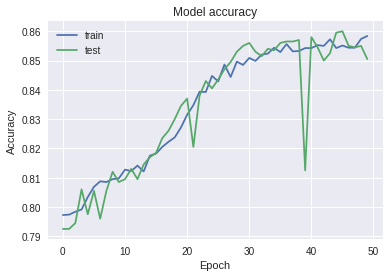

In [41]:
# Model Accuracy 
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

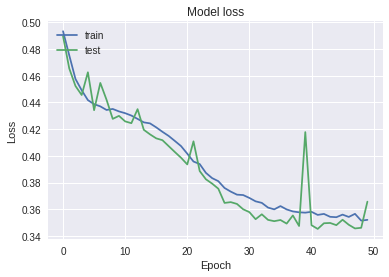

In [42]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
test_y_pred = model.predict(X_test_scaled)

In [44]:
accuracy = model.evaluate(x=X_train_scaled,y=train_Y,verbose=0)
print("Accuracy - Train: ", accuracy[1])

accuracy = model.evaluate(x=X_test_scaled,y=test_Y,verbose=0)
print("Accuracy - Test: ", accuracy[1])

Accuracy - Train:  0.85275
Accuracy - Test:  0.8505


#### Optimize the model

In [0]:
# Tune batch size, epochs and Optimizer
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
optimizer = ['SGD', 'Adam']

In [0]:
params = dict(epochs = epochs,batch_size=batch_size,optimizer=optimizer)

In [0]:
def new_model(optimizer='SGD'):
    new_model1 = Sequential()
    new_model1.add(Dense(250, activation='sigmoid', input_shape=(X_col,)))
    new_model1.add(Dense(units=250,activation="relu"))
    new_model1.add(Dense(units=250,activation="relu"))
    new_model1.add(Dense(units=2,activation="softmax"))
    new_model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model1

In [0]:
seed = 7
np.random.seed(seed)

In [0]:
new_model1 = KerasClassifier(build_fn=new_model,verbose=0)
grid = GridSearchCV(estimator=new_model1, param_grid=params, n_jobs=-1)

In [0]:
grid_result = grid.fit(X_train_scaled, train_Y, 
                      validation_data=(X_test_scaled, test_Y))

In [51]:
grid_result.best_score_

0.8557499976828694

In [52]:
grid_result.best_params_

{'batch_size': 20, 'epochs': 50, 'optimizer': 'Adam'}

In [53]:
mean_score = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean_score, params in zip (mean_score,params):
    print("%f with %r" % (mean_score, params))

0.825500 with {'batch_size': 10, 'epochs': 10, 'optimizer': 'SGD'}
0.831875 with {'batch_size': 10, 'epochs': 10, 'optimizer': 'Adam'}
0.853750 with {'batch_size': 10, 'epochs': 50, 'optimizer': 'SGD'}
0.853750 with {'batch_size': 10, 'epochs': 50, 'optimizer': 'Adam'}
0.815250 with {'batch_size': 10, 'epochs': 100, 'optimizer': 'SGD'}
0.848875 with {'batch_size': 10, 'epochs': 100, 'optimizer': 'Adam'}
0.807375 with {'batch_size': 20, 'epochs': 10, 'optimizer': 'SGD'}
0.838375 with {'batch_size': 20, 'epochs': 10, 'optimizer': 'Adam'}
0.848250 with {'batch_size': 20, 'epochs': 50, 'optimizer': 'SGD'}
0.855750 with {'batch_size': 20, 'epochs': 50, 'optimizer': 'Adam'}
0.854375 with {'batch_size': 20, 'epochs': 100, 'optimizer': 'SGD'}
0.849000 with {'batch_size': 20, 'epochs': 100, 'optimizer': 'Adam'}
0.800375 with {'batch_size': 40, 'epochs': 10, 'optimizer': 'SGD'}
0.853125 with {'batch_size': 40, 'epochs': 10, 'optimizer': 'Adam'}
0.844250 with {'batch_size': 40, 'epochs': 50, 'opt

In [0]:
def new_model(learn_rate=0.01, momentum=0):
    new_model2 = Sequential()
    new_model2.add(Dense(250, activation='sigmoid', input_shape=(X_col,)))
    new_model2.add(Dense(units=250,activation="relu"))
    new_model2.add(Dense(units=250,activation="relu"))
    new_model2.add(Dense(units=2,activation="softmax"))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    new_model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model2

In [0]:
learn_rate = [0.001, 0.01, 0.1]
momentum = [0.0, 0.2, 0.4, 0.6]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)

In [0]:
seed = 7
np.random.seed(seed)

In [0]:
new_model2 = KerasClassifier(build_fn=new_model,epochs = 100, batch_size = 20,verbose=0)
grid = GridSearchCV(estimator=new_model2, param_grid=param_grid, n_jobs=-1)

In [0]:
grid_result = grid.fit(X_train_scaled, train_Y, 
                      validation_data=(X_test_scaled, test_Y))

In [59]:
grid_result.best_score_

0.8576249982416629

In [60]:
grid_result.best_params_

{'learn_rate': 0.01, 'momentum': 0.0}

In [61]:
mean_score = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean_score, params in zip (mean_score,params):
    print("%f with %r" % (mean_score, params))

0.816000 with {'learn_rate': 0.001, 'momentum': 0.0}
0.819250 with {'learn_rate': 0.001, 'momentum': 0.2}
0.825250 with {'learn_rate': 0.001, 'momentum': 0.4}
0.851000 with {'learn_rate': 0.001, 'momentum': 0.6}
0.857625 with {'learn_rate': 0.01, 'momentum': 0.0}
0.852000 with {'learn_rate': 0.01, 'momentum': 0.2}
0.851125 with {'learn_rate': 0.01, 'momentum': 0.4}
0.855000 with {'learn_rate': 0.01, 'momentum': 0.6}
0.814125 with {'learn_rate': 0.1, 'momentum': 0.0}
0.833750 with {'learn_rate': 0.1, 'momentum': 0.2}
0.817250 with {'learn_rate': 0.1, 'momentum': 0.4}
0.817625 with {'learn_rate': 0.1, 'momentum': 0.6}


#### Predicting the result using .5 as thresehold

In [0]:
# Finalize the Model
batch_size = 20
epochs = 50
optimizer = SGD
learning_rate = 0.001
momentum = 0.8

new_model3 = Sequential()
new_model3.add(Dense(250, activation='sigmoid', input_shape=(X_col,)))
new_model3.add(Dense(units=250,activation="relu"))
new_model3.add(Dense(units=250,activation="relu"))
new_model3.add(Dense(units=2,activation="softmax"))
optimizer = SGD(lr=learn_rate, momentum=momentum)
new_model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
new_model3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
history = new_model3.fit(X_train_scaled, train_Y, 
          validation_data=(X_test_scaled, test_Y), 
          epochs=epochs,
          batch_size = batch_size,
          verbose = 2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
 - 1s - loss: 0.4880 - acc: 0.7953 - val_loss: 0.4923 - val_acc: 0.7925
Epoch 2/50
 - 1s - loss: 0.4600 - acc: 0.7986 - val_loss: 0.4430 - val_acc: 0.8000
Epoch 3/50
 - 1s - loss: 0.4455 - acc: 0.8025 - val_loss: 0.4328 - val_acc: 0.8045
Epoch 4/50
 - 1s - loss: 0.4391 - acc: 0.8046 - val_loss: 0.4423 - val_acc: 0.8045
Epoch 5/50
 - 1s - loss: 0.4383 - acc: 0.8061 - val_loss: 0.4277 - val_acc: 0.8080
Epoch 6/50
 - 1s - loss: 0.4327 - acc: 0.8121 - val_loss: 0.4261 - val_acc: 0.8090
Epoch 7/50
 - 1s - loss: 0.4308 - acc: 0.8135 - val_loss: 0.4212 - val_acc: 0.8140
Epoch 8/50
 - 1s - loss: 0.4273 - acc: 0.8160 - val_loss: 0.4214 - val_acc: 0.8135
Epoch 9/50
 - 1s - loss: 0.4221 - acc: 0.8181 - val_loss: 0.4135 - val_acc: 0.8205
Epoch 10/50
 - 1s - loss: 0.4170 - acc: 0.8211 - val_loss: 0.4086 - val_acc: 0.8245
Epoch 11/50
 - 1s - loss: 0.4117 - acc: 0.8225 - val_loss: 0.4108 - val_acc: 0.8145
Epoch 12/50
 - 1s - loss: 0.4052 - ac

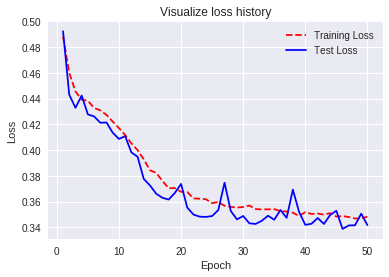

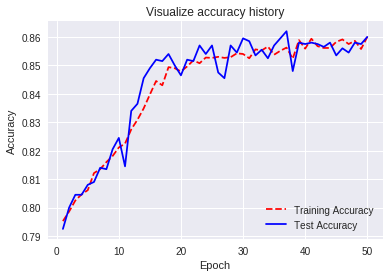

In [66]:
# Get training and test loss histories and also accuracies
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['acc']
test_acc = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.title('Visualize loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Visualize accuracy history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.title('Visualize accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [68]:
y_pred=new_model3.predict(X_test_scaled)
# Printing the first 5 predicted probabilities of target variable
y_pred[0:5]

array([[0.95778066, 0.04221934],
       [0.9103877 , 0.08961234],
       [0.9578722 , 0.04212783],
       [0.95793283, 0.04206714],
       [0.9405434 , 0.05945662]], dtype=float32)

In [69]:
accuracy = new_model3.evaluate(x=X_train_scaled,y=train_Y,verbose=0)
print("Training Accuracy: ", accuracy[1])
accuracy = new_model3.evaluate(x=X_test_scaled,y=test_Y,verbose=0)
print("Test Accuracy: ", accuracy[1])

Training Accuracy:  0.85975
Test Accuracy:  0.86


In [71]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

matrix = metrics.confusion_matrix(test_Y.argmax(axis=1), y_pred.argmax(axis=1))
print("Confusion Matrix")
print(matrix)

Confusion Matrix
[[1542   43]
 [ 237  178]]
